# Initial Setup

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import cv2  # Import OpenCV

import os
import joblib

from google.colab import drive
drive.mount('/content/drive')

# Load and preprocess the dataset
(dataset_train, dataset_val), dataset_info = tfds.load(
    'malaria',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True
)

Mounted at /content/drive


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteGJ09EZ/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


# Analysis of the dataset

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

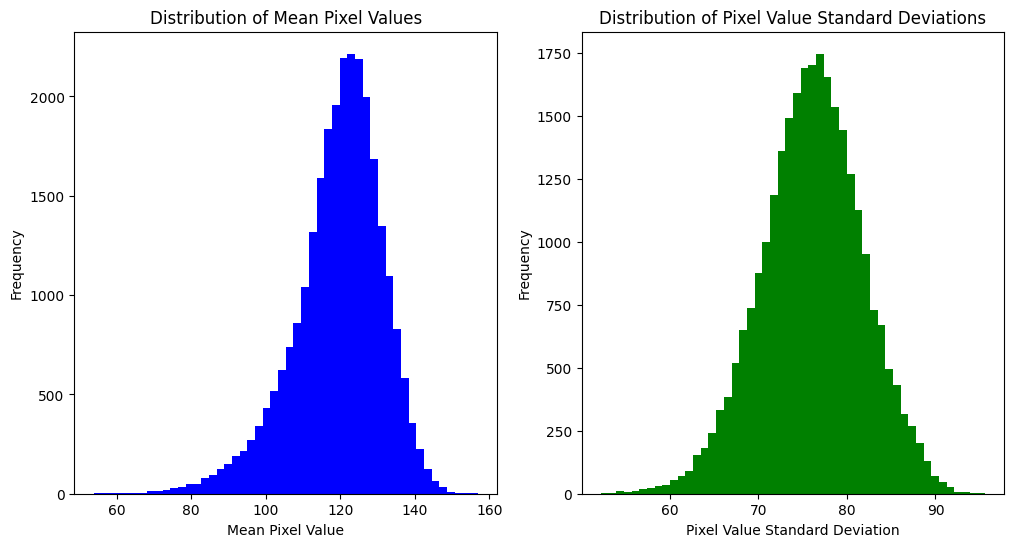

Average variance: 5816.724103975411
Average standard deviation: 76.05191508769592


In [ ]:
# statistical analysis of the dataset
print(ds_info)

ds, ds_info = tfds.load('malaria', split='train', with_info=True)

# Function to extract images and labels from the dataset
def extract_images_and_labels(dataset, size=(64, 64)):
    images, labels = [], []
    for example in tfds.as_numpy(dataset):
        # Resize the image to the desired size
        img = cv2.resize(example['image'], size)
        images.append(img)
        labels.append(example['label'])
    # Convert the list of arrays to a single 4D numpy array (num_images, height, width, channels)
    return np.array(images), np.array(labels)

# Load image data
images, labels = extract_images_and_labels(ds)

# Calculate basic statistics
num_samples = len(images)
num_parasitized = np.sum(labels == 1)
num_uninfected = np.sum(labels == 0)
image_shape = images[0].shape

print(f"Total number of samples: {num_samples}")
print(f"Number of parasitized images: {num_parasitized}")
print(f"Number of uninfected images: {num_uninfected}")
print(f"Shape of each image: {image_shape}")

# Analyze the distribution of image pixel values
flattened_images = images.reshape(num_samples, -1)
mean_pixel_value = np.mean(flattened_images, axis=1)
std_pixel_value = np.std(flattened_images, axis=1)

# Visualize pixel value distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(mean_pixel_value, bins=50, color='blue')
plt.title('Distribution of Mean Pixel Values')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(std_pixel_value, bins=50, color='green')
plt.title('Distribution of Pixel Value Standard Deviations')
plt.xlabel('Pixel Value Standard Deviation')
plt.ylabel('Frequency')

plt.show()

# Calculate variance and standard deviation of pixel values
variances = np.var(flattened_images, axis=1)
standard_deviations = np.std(flattened_images, axis=1)

print(f"Average variance: {np.mean(variances)}")
print(f"Average standard deviation: {np.mean(standard_deviations)}")

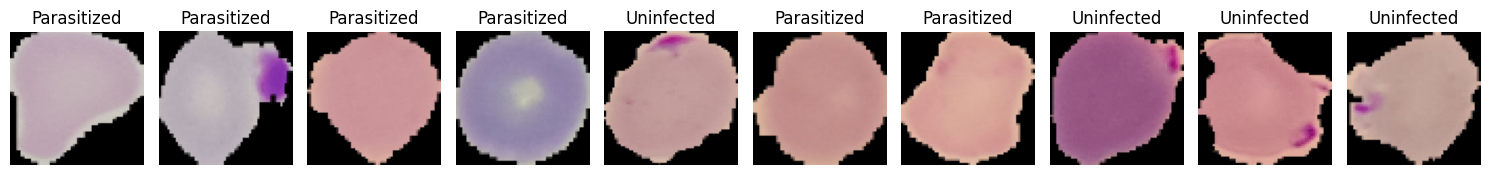

In [ ]:
# Visualization of the dataset

# Select image samples for visualization
num_images_to_show = 10
indices = np.random.choice(range(num_samples), num_images_to_show)

# Visualize the images
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(images[idx])
    plt.title('Parasitized' if labels[idx] == 1 else 'Uninfected')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Pre-Processing

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Updated preprocessing function to include data augmentation
def preprocess_with_augmentation(image, label):
    image = data_augmentation(image)
    image = tf.image.resize(image, [64, 64])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply data augmentation to the training data
train_data_augmented = dataset_train.map(preprocess_with_augmentation).cache().batch(32).prefetch(tf.data.AUTOTUNE)
validation_data_augmented = dataset_val.map(preprocess_with_augmentation).cache().batch(32).prefetch(tf.data.AUTOTUNE)

# CNN

In [ ]:
# Loading the model
cnn_model_path = 'Model3_CNN_Model.h5'
cnn_model_loaded = False

# Check if a file containing the trained model (Load the pre-trained model if it exists)
if os.path.exists(cnn_model_path):
    cnn_model = load_model(cnn_model_path)
    cnn_model_loaded = True
    print("Loaded saved cnn model.")
else:
    print("No saved cnn model found. Proceeding to train a new model.")

No saved cnn model found. Proceeding to train a new model.


Epoch 1/10
603/603 - 69s - loss: 0.6189 - accuracy: 0.7061 - val_loss: 0.4466 - val_accuracy: 0.8659 - 69s/epoch - 115ms/step
Epoch 2/10
603/603 - 4s - loss: 0.3687 - accuracy: 0.8894 - val_loss: 0.3288 - val_accuracy: 0.9101 - 4s/epoch - 6ms/step
Epoch 3/10
603/603 - 4s - loss: 0.3257 - accuracy: 0.9049 - val_loss: 0.3027 - val_accuracy: 0.9197 - 4s/epoch - 7ms/step
Epoch 4/10
603/603 - 4s - loss: 0.3378 - accuracy: 0.8776 - val_loss: 0.3080 - val_accuracy: 0.9144 - 4s/epoch - 7ms/step
Epoch 5/10
603/603 - 4s - loss: 0.3043 - accuracy: 0.9074 - val_loss: 0.2866 - val_accuracy: 0.9225 - 4s/epoch - 6ms/step
Epoch 6/10
603/603 - 4s - loss: 0.2899 - accuracy: 0.9136 - val_loss: 0.2725 - val_accuracy: 0.9242 - 4s/epoch - 6ms/step
Epoch 7/10
603/603 - 4s - loss: 0.2844 - accuracy: 0.9135 - val_loss: 0.2655 - val_accuracy: 0.9196 - 4s/epoch - 6ms/step
Epoch 8/10
603/603 - 4s - loss: 0.2776 - accuracy: 0.9130 - val_loss: 0.2725 - val_accuracy: 0.9079 - 4s/epoch - 6ms/step
Epoch 9/10
603/603 -

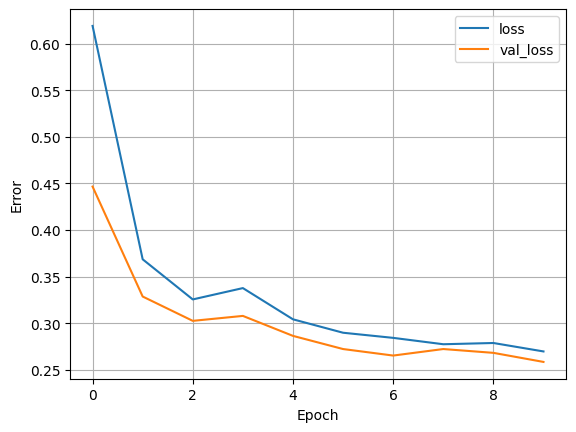

CNN Model has been saved to Model3_CNN_Model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
if not cnn_model_loaded:

  # Create the CNN model with Dropout and L2 regularization
  def create_cnn_model():
      model = Sequential([
          Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=l2(0.001)),
          MaxPooling2D((2, 2)),
          Dropout(0.2),
          Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
          MaxPooling2D((2, 2)),
          Dropout(0.2),
          Flatten(),
          Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
          Dropout(0.2),
          Dense(1, activation='sigmoid')
      ])
      model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
      return model

  # Initialize the CNN model
  cnn_model = create_cnn_model()

  # Define early stopping criteria
  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  # Train the CNN model with regularization, dropout, and early stopping
  cnn_history = cnn_model.fit(
      train_data_augmented,
      epochs=10,
      verbose=2,
      validation_data=validation_data_augmented,
      callbacks=[early_stopping]
  )

  # Plot the training and validation loss over epochs
  def plot_loss(history):
      plt.plot(history.history['loss'], label='loss')
      plt.plot(history.history['val_loss'], label='val_loss')
      plt.xlabel('Epoch')
      plt.ylabel('Error')
      plt.legend()
      plt.grid(True)
      plt.show()

  plot_loss(cnn_history)

  # Save the trained CNN model
  cnn_model.save(cnn_model_path)
  print("CNN Model has been saved to", cnn_model_path)

In [ ]:
# Evaluate the CNN model
cnn_predictions = cnn_model.predict(validation_data_augmented).flatten()
cnn_predictions = np.where(cnn_predictions > 0.5, 1, 0)

# Fetch the true labels from the validation dataset
y_true = [y.numpy() for x, y in validation_data_augmented.unbatch()]

# Calculate metrics for the CNN model
cnn_accuracy = accuracy_score(y_true, cnn_predictions)
cnn_precision = precision_score(y_true, cnn_predictions)
cnn_recall = recall_score(y_true, cnn_predictions)
cnn_f1_score = f1_score(y_true, cnn_predictions)

# Print the evaluation metrics for the CNN model
print(f"CNN Model Accuracy: {cnn_accuracy}")
print(f"CNN Model Precision: {cnn_precision}")
print(f"CNN Model Recall: {cnn_recall}")
print(f"CNN Model F1 Score: {cnn_f1_score}")

259/259 [==============================] - 1s 2ms/step
CNN Model Accuracy: 0.9243982097496068
CNN Model Precision: 0.925242718446602
CNN Model Recall: 0.9232259627028336
CNN Model F1 Score: 0.924233240392775


# Decision Tree

In [ ]:
# Loading the dt model
dt_model_path = 'Model3_DT_Model.joblib'
dt_model_loaded = False

# Check if a file containing the trained model (Load the pre-trained model if it exists)
if os.path.exists(dt_model_path):
    dt_model = joblib.load(dt_model_path)
    dt_model_loaded = True
    print("Loaded saved dt model.")
else:
    print("No saved Dt model found. Proceeding to train a new model.")

No saved Dt model found. Proceeding to train a new model.


In [ ]:
if not dt_model_loaded:

  # Prepare the image data for the Decision Tree
  def prepare_data_for_dt(dataset):
      images, labels = [], []
      for image_batch, label_batch in dataset:
          images.append(image_batch.numpy())
          labels.append(label_batch.numpy())
      # Concatenate all batches
      images = np.concatenate(images, axis=0)
      labels = np.concatenate(labels, axis=0)
      return images.reshape(images.shape[0], -1), labels  # Reshape images to 1D per sample

  # Use the defined function to prepare data
  train_images_flat, train_labels = prepare_data_for_dt(train_data_augmented)
  val_images_flat, val_labels = prepare_data_for_dt(validation_data_augmented)

  # Create and train the Decision Tree model
  dt_model = DecisionTreeClassifier(max_depth=5)
  dt_model.fit(train_images_flat, train_labels)

  # Save the trained DT model
  joblib.dump(dt_model, dt_model_path)
  print("DT Model has been saved to", dt_model_path)

DT Model has been saved to Model3_DT_Model.joblib


In [ ]:
# Evaluate the Decision Tree model
dt_predictions = dt_model.predict(val_images_flat)

# Calculate metrics
dt_accuracy = accuracy_score(val_labels, dt_predictions)
dt_precision = precision_score(val_labels, dt_predictions)
dt_recall = recall_score(val_labels, dt_predictions)
dt_f1_score = f1_score(val_labels, dt_predictions)

# Print the evaluation metrics for the Decision Tree model
print(f"Decision Tree Model Accuracy: {dt_accuracy}")
print(f"Decision Tree Model Precision: {dt_precision}")
print(f"Decision Tree Model Recall: {dt_recall}")
print(f"Decision Tree Model F1 Score: {dt_f1_score}")

Decision Tree Model Accuracy: 0.6934801016088061
Decision Tree Model Precision: 0.6695726132256007
Decision Tree Model Recall: 0.7626543957374667
Decision Tree Model F1 Score: 0.7130887681159421


# Ensemble Model

Evaluating ensemble model...
Ensemble Model Accuracy: 0.8452884964315955
Ensemble Model Precision: 0.9450343535290443
Ensemble Model Recall: 0.7328651005085978
Ensemble Model F1 Score: 0.8255353976265175


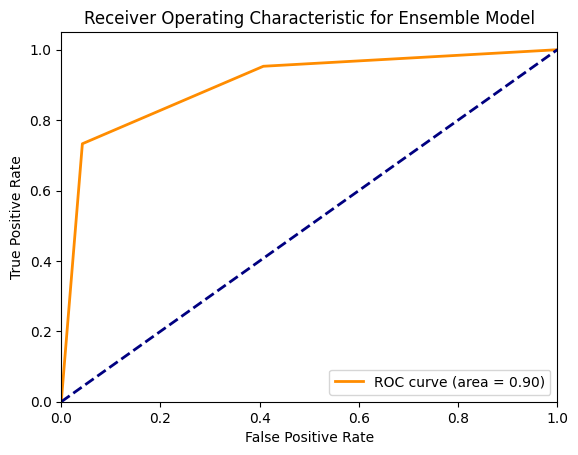

In [ ]:
# Create an ensemble prediction
ensemble_predictions = (cnn_predictions + dt_predictions) / 2
ensemble_predictions = np.round(ensemble_predictions)

# Evaluate the ensemble model
print('Evaluating ensemble model...')
ensemble_accuracy = accuracy_score(val_labels, ensemble_predictions)
ensemble_precision = precision_score(val_labels, ensemble_predictions)
ensemble_recall = recall_score(val_labels, ensemble_predictions)
ensemble_f1 = f1_score(val_labels, ensemble_predictions)

# Print the evaluation metrics
print(f'Ensemble Model Accuracy: {ensemble_accuracy}')
print(f'Ensemble Model Precision: {ensemble_precision}')
print(f'Ensemble Model Recall: {ensemble_recall}')
print(f'Ensemble Model F1 Score: {ensemble_f1}')

ensemble_probabilities = (cnn_predictions + dt_predictions) / 2

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(val_labels, ensemble_probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Ensemble Model')
plt.legend(loc="lower right")
plt.show()
plt.close()